In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Загрузка данных из Kaggle
# kaggle competitions download -c mipt-dl-captcha

In [7]:
# Загрузка данных
labels = np.load('data/labels.npy')
images = np.load('data/images.npy')

In [8]:
# Применение фильтров к изображению
def preprocess_image(image):
    # Преобразование в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Усиление контрастности с помощью CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Нормализация и добавление оси канала
    normalized = enhanced / 255.0
    processed_image = np.expand_dims(normalized, axis=-1)

    # Повторное преобразование в формат RGB
    processed_image = np.repeat(processed_image, 3, axis=-1)
    
    return processed_image

In [9]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Нормализация изображений
X_train = X_train / 255.0
X_test = X_test / 255.0

# Кодирование меток в формат one-hot
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)


In [10]:
# Создание модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(label_binarizer.classes_), activation='softmax')
])

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Использование callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.0583 - loss: 4.1185 - val_accuracy: 0.1300 - val_loss: 3.5075 - learning_rate: 0.0010
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.1639 - loss: 3.2398 - val_accuracy: 0.2710 - val_loss: 3.0858 - learning_rate: 0.0010
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.3538 - loss: 2.4939 - val_accuracy: 0.5483 - val_loss: 1.8746 - learning_rate: 0.0010
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.4934 - loss: 2.0300 - val_accuracy: 0.6010 - val_loss: 1.7291 - learning_rate: 0.0010
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.5905 - loss: 1.7366 - val_accuracy: 0.6750 - val_loss: 1.5199 - learning_rate: 0.0010
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.6666 - loss: 1.5534 - val_accuracy: 0.7258 - val_loss: 1.4175 - learning_rate: 0.0010
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.7166 - l

In [12]:
# Оценка модели
test_loss, test_accuracy = model.evaluate(X_test, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8564 - loss: 0.7508


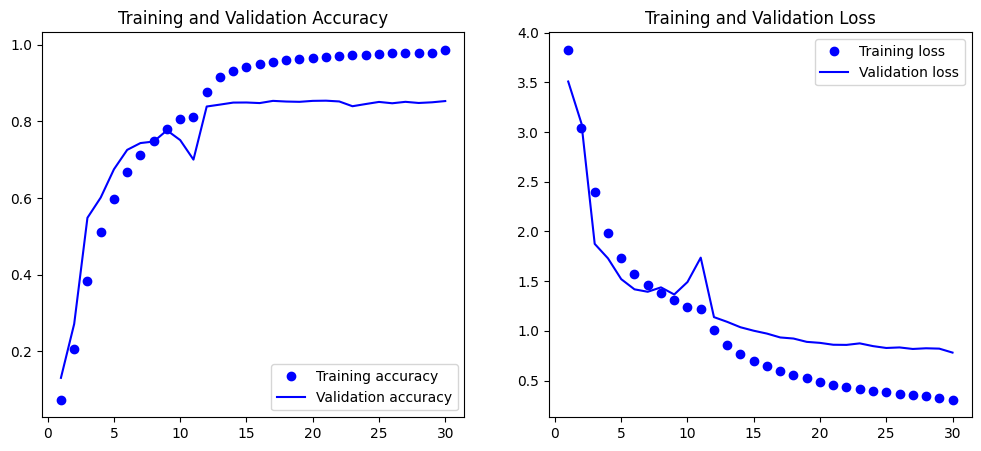

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [20]:
# Загрузка данных для предсказания
images_sub = np.load('data/images_sub.npy')

In [21]:
# Нормализация изображений
images_sub = images_sub / 255.0
# Выполнение предсказаний
predictions = model.predict(images_sub)
predicted_labels = label_binarizer.inverse_transform(predictions)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


In [16]:
# Создание DataFrame для отправки
submission = pd.DataFrame({'Id': np.arange(len(predicted_labels)), 'Category': predicted_labels})

# Проверка формата ответа
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        50000 non-null  int64
 1   Category  50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB


In [17]:
# Сохранение файла
submission.to_csv('data/predictions.csv', index=False)